# Plotting results of predictions




In [1]:
import folium
import odc.geo
import numpy as np
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from odc.geo.xr import assign_crs
from odc.algo import xr_reproject
from datacube.utils.cog import write_cog
from matplotlib.colors import ListedColormap

import sys
sys.path.append('/g/data/os22/chad_tmp/NEE_modelling/')
from collect_prediction_data import allNaN_arg

sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools/')
from dea_tools.spatial import xr_rasterize

import warnings
warnings.filterwarnings("ignore")

## Analysis Parameters

In [2]:
var = 'ER'
suffix='20221212'
results_name = var+'_2003_2021_5km_LGBM_'+suffix+'.nc'
mask_path = '/g/data/os22/chad_tmp/NEE_modelling/results/prediction_data/mask_5km.nc'

# upper = 'NEE_2003_2021_5km_LGBM_quantiles.nc'

### Open predictions

In [3]:
ds = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/'+results_name)
ds.attrs['nodata'] = np.nan
# ds = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/5km/GOSIF_GPP_5km_monthly_2002_2021.nc')

# ds_upper = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/'+upper)

# ds_lower = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/'+lower)

### Create a mask

In [4]:
# data = xr.open_dataset(data_path).FPAR
# mask = data.isnull().any('time')
# mask =  xr.open_dataarray(mask_path)

In [5]:
# ds = ds.where(~mask)

## Facet plots

In [6]:
# year='2011'
# ds.sel(time=year).plot.imshow(col='time', col_wrap=6, robust=True); 

In [7]:
# year='2019'
# ds.sel(time=year).plot.imshow(col='time', col_wrap=6,  robust=True);

## Convert to PgC/year

In [8]:
grid = ds.odc.geobox.to_crs('EPSG:3577')

In [9]:
ds = xr_reproject(ds, geobox=grid.compat, resampling='bilinear')
# ds_upper = xr_reproject(ds_upper, geobox=grid.compat, resampling='nearest')
# ds_upper = xr_reproject(ds_upper, geobox=grid.compat, resampling='nearest')
# mask = xr_reproject(mask.astype(np.int8), geobox=grid.compat, resampling='nearest')

In [10]:
area_per_pixel = ds.geobox.resolution[1]**2

ds = ds * area_per_pixel * 1e-15 * 12

# ds_upper = ds_upper * area_per_pixel * 1e-15 *12
# ds_lower = ds_lower * area_per_pixel * 1e-15 *12


## Fire emissions

In [11]:
fire = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/FireEmissions_10km_monthly_2003_2021.nc')
fire = fire.sum(['x', 'y'])
fire = fire*12

## Zonal summaries

In [12]:
ds_1D = ds.sum(['x','y'])
ds_fire_1d = ds_1D+fire
# ds_upper_1D = ds_upper.sum(['x','y'])
# ds_lower_1D = ds_lower.sum(['x','y'])

# ds_1D = ds.sum(['latitude','longitude'])

In [13]:
# mask = xr.where(ds==0, 0, 1)
# ds = ds.where(mask)

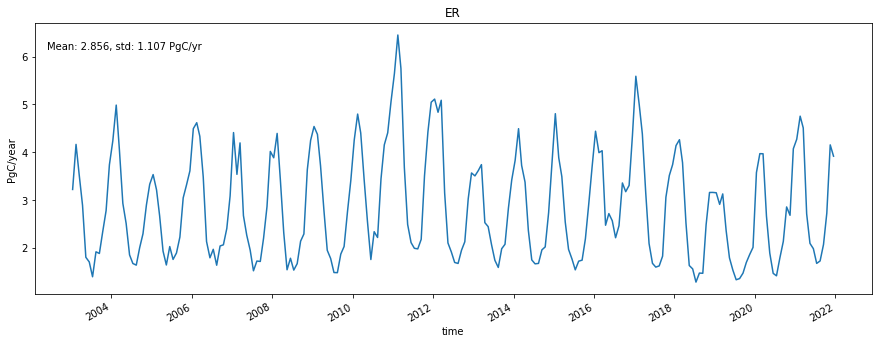

In [14]:
fig,ax = plt.subplots(1,1, figsize=(15,5))

ds_1D.plot(linestyle='-', ax=ax, label=var)
# ax.fill_between(ds_1D.time, ds_upper_1D.sel(quantile=0.25),
#                 ds_upper_1D.sel(quantile=0.75), alpha=0.2)


if var == 'NEE':
    ds_fire_1d.plot(linestyle='--', ax=ax, label='NEE+Fire')
    ax.text(.015, .95, f'Mean: {ds_fire_1d.mean().values:.3f}, std: {ds_fire_1d.std().values:.3f} PgC/yr',
        transform=ax.transAxes)
    plt.axhline(0, c='grey', linestyle='--')
    # ax.legend(loc='lower right')

ax.text(.015, .90, f'Mean: {ds_1D.mean().values:.3f}, std: {ds_1D.std().values:.3f} PgC/yr',
        transform=ax.transAxes);

plt.title(var)
plt.ylabel('PgC/year');


## Plots per bioregion

In [16]:
gdf = gpd.read_file('/g/data/os22/chad_tmp/NEE_modelling/data/bioclimatic_regions.geojson')
gdf.head()

,bioclimatic_regions,region_name,geometry
0,1.0,Tropics,"MULTIPOLYGON (((122.92500 -16.42500, 122.92500..."
1,2.0,Savanna,"MULTIPOLYGON (((147.67500 -19.87500, 147.72500..."
2,3.0,Warm Temperate,"MULTIPOLYGON (((145.42500 -36.02500, 145.42500..."
3,4.0,Cool Temperate,"MULTIPOLYGON (((147.07500 -43.37500, 147.12500..."
4,5.0,Mediterranean,"MULTIPOLYGON (((135.82500 -34.87500, 135.82500..."


In [17]:
# Dictionary to save results 
results = {}
for index, row in gdf.iterrows():
    print(row['region_name'])

    # Generate a polygon mask to keep only data within the polygon
    mask = xr_rasterize(gdf.iloc[[index]], ds)
    
    # Mask dataset to set pixels outside the polygon to `NaN`
    dss = ds.where(mask)
    
    # Append results to a dictionary using the attribute
    # column as an key
    results.update({row['region_name']: dss})

Tropics
Savanna
Warm Temperate
Cool Temperate
Mediterranean
Desert


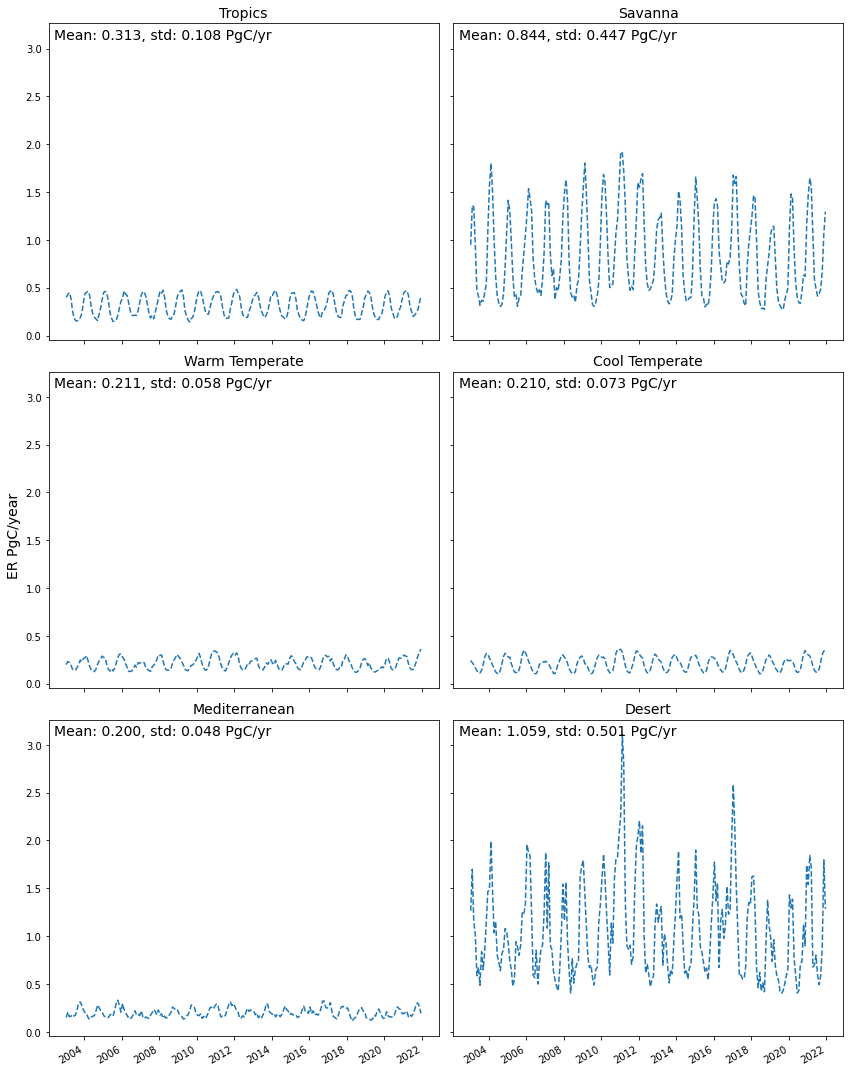

In [18]:
fig, axs = plt.subplots(3,2, figsize=(12,15), sharex=True, sharey=True)

for ax, k in zip(axs.ravel(), results.keys()):
    
    _1D = results[k].sum(['x','y'])
    
    _1D.plot(linestyle='--', ax=ax, label=var, )
    ax.text(.015, .95, f'Mean: {_1D.mean().values:.3f}, std: {_1D.std().values:.3f} PgC/yr',
        transform=ax.transAxes, fontdict={'fontsize': 14})
    if var=='NEE':
        ax.axhline(0, c='grey', linestyle='--')
    ax.set_title(k, fontdict={'fontsize': 14})
    ax.set_ylabel('')
    ax.set_xlabel('')

fig.supylabel(var+' PgC/year', fontsize=14)
plt.tight_layout()
plt.savefig('/g/data/os22/chad_tmp/NEE_modelling/results/figs/'+var+'_bioregion.png')

## Per-pixel summaries

In [19]:
annual_mean = ds.resample(time='1Y').sum().mean('time')
annual_std = ds.resample(time='1Y').sum().std('time')
scaled_variance = annual_std / annual_mean

In [20]:
# write_cog(annual_mean, '/g/data/os22/chad_tmp/NEE_modelling/results/predictions/NEE_annual_mean.tif')
# write_cog(annual_std, '/g/data/os22/chad_tmp/NEE_modelling/results/predictions/NEE_annual_std.tif')

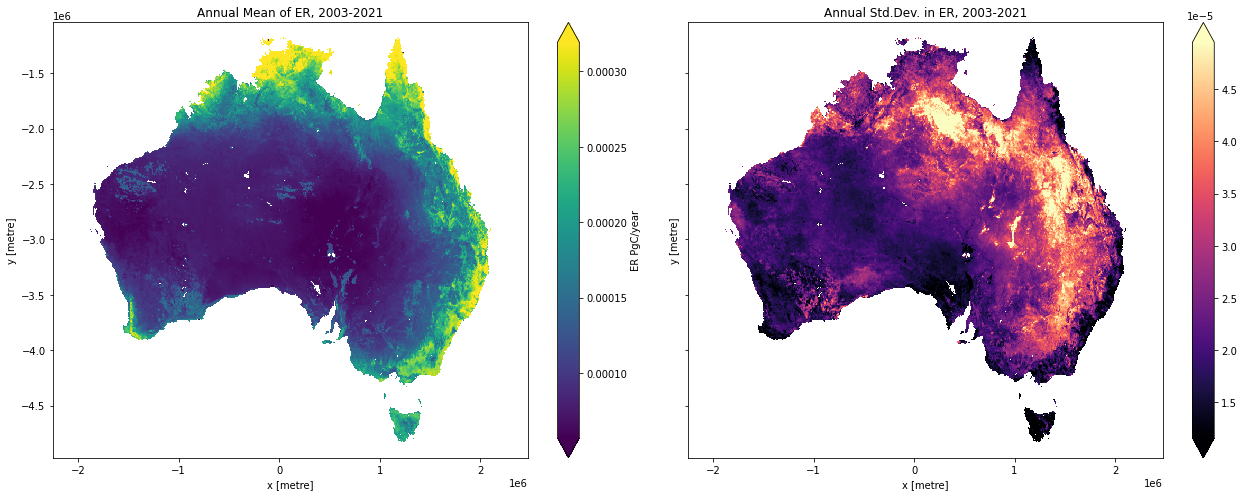

In [21]:
fig,ax = plt.subplots(1,2, figsize=(18,7), sharey=True)

if var == 'NEE':
    annual_mean.rename(var+' PgC/year').where(annual_mean!=0).plot.imshow(ax=ax[0], cmap='RdBu_r', robust=True)  #cmap='RdBu_r'
else:
    annual_mean.rename(var+' PgC/year').where(annual_mean!=0).plot.imshow(ax=ax[0], cmap='viridis', robust=True)  #cmap='RdBu_r'
annual_std.rename('').where(annual_mean!=0).plot.imshow(ax=ax[1], cmap='magma', robust=True)
# np.absolute(scaled_variance.rename('')).plot.imshow(ax=ax[1],cmap='magma', robust=True)
ax[0].set_title('Annual Mean of '+var+', 2003-2021')
ax[1].set_title('Annual Std.Dev. in '+var+', 2003-2021')
# ax[1].set_title('Coefficient of Variation, '+var+', 2003-2021')
# plt.suptitle('Annual Mean and Std. Dev. of GPP, 2003-2021')
plt.tight_layout();

In [22]:
monthly_mean = ds.groupby('time.month').mean() #.sel(time=slice('2003','2015'))
# monthly_season = ds.groupby('time.season').mean()
# monthly_std = ds.groupby('time.month').std()
# cv_monthly = monthly_std / monthly_mean

In [23]:
if var == 'NEE':
    max_mean_month = allNaN_arg(monthly_mean, 'month', 'min')
    # max_mean_season = allNaN_arg(monthly_season, 'season', 'min')
else:
    max_mean_month = allNaN_arg(monthly_mean, 'month', 'max')
    # max_mean_season = allNaN_arg(monthly_season, 'season', 'max')

In [24]:
# mask = xr.where(ds.isel(time=1)==0, 1, 0)

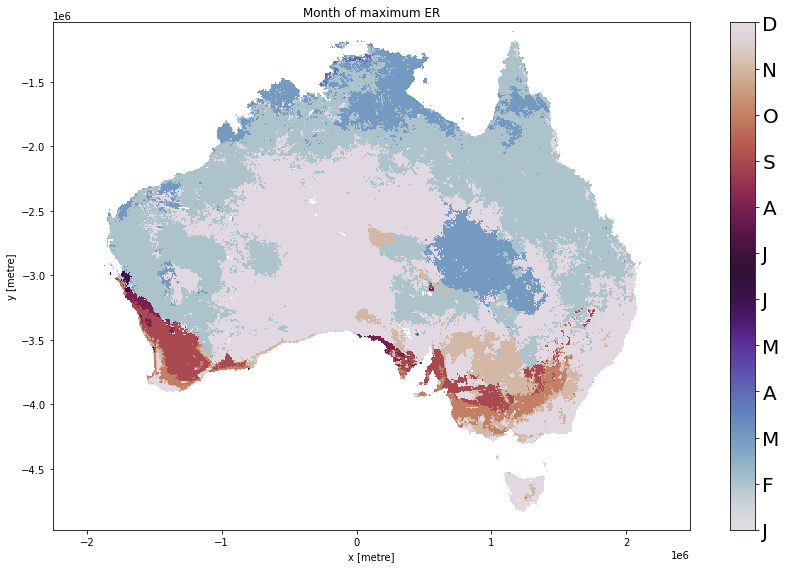

In [25]:
fig,ax = plt.subplots(1,1, figsize=(12,8), sharey=True)

im = max_mean_month.plot.imshow(vmin=1, vmax=12, ax=ax, cmap='twilight', add_colorbar=False)
cbar = plt.colorbar(im, spacing='uniform', ax=ax)
cbar.set_ticks([1,2,3,4,5,6,7,8,9,10,11,12])
cbar.set_ticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"], fontsize=20)
ax.set_title('Month of maximum '+var);

# cmap = ListedColormap(['lightsteelblue', 'cornflowerblue', 'royalblue', 'darkblue'])
# im1 = max_mean_season.plot.imshow(vmin=1, vmax=4, cmap=cmap, add_colorbar=False, ax=ax[1])
# cbar1 = plt.colorbar(im1, spacing='uniform', ax=ax[1])
# cbar1.set_ticks([1, 2, 3, 4])
# cbar1.set_ticklabels(["DJF", "MAM", "JJA", "SON"])
# ax[1].set_title('Season of maximum '+var)
plt.tight_layout();

In [26]:
# monthly_mean.where(~mask).plot.imshow(col='month', col_wrap=6, robust=True); #cmap='RdBu_r'

In [27]:
# monthly_std.where(~mask).plot.imshow(col='month', col_wrap=6,robust=True, cmap='magma');

In [28]:
# np.absolute(cv_monthly).where(~mask).plot.imshow(col='month', col_wrap=6,robust=True, cmap='magma');

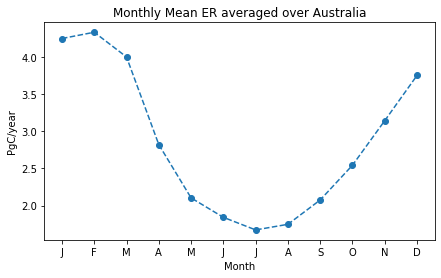

In [29]:
y = monthly_mean.sum(['x','y']).values
x = monthly_mean.month.values
# std = monthly_std.mean(['x','y']).values

fig,ax = plt.subplots(1,1, figsize=(7,4))
ax.plot(x, y, marker='o', linestyle='--')
if var=='NEE':
    ax.axhline(0, c='grey')
# ax.fill_between(x, y-std, y+std, alpha=0.5)
ax.set_title('Monthly Mean '+var+' averaged over Australia')
ax.set_xticks(range(1,13))
ax.set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"]) 
ax.set_xlabel('Month');
ax.set_ylabel('PgC/year');


## Per bioregion climatology

In [30]:
# Dictionary to save results 
results = {}
for index, row in gdf.iterrows():
    print(row['region_name'])

    # Generate a polygon mask to keep only data within the polygon
    mask = xr_rasterize(gdf.iloc[[index]], ds)
    
    # Mask dataset to set pixels outside the polygon to `NaN`
    dss = monthly_mean.where(mask)
    
    # Append results to a dictionary using the attribute
    # column as an key
    results.update({row['region_name']: dss})

Tropics
Savanna
Warm Temperate
Cool Temperate
Mediterranean
Desert


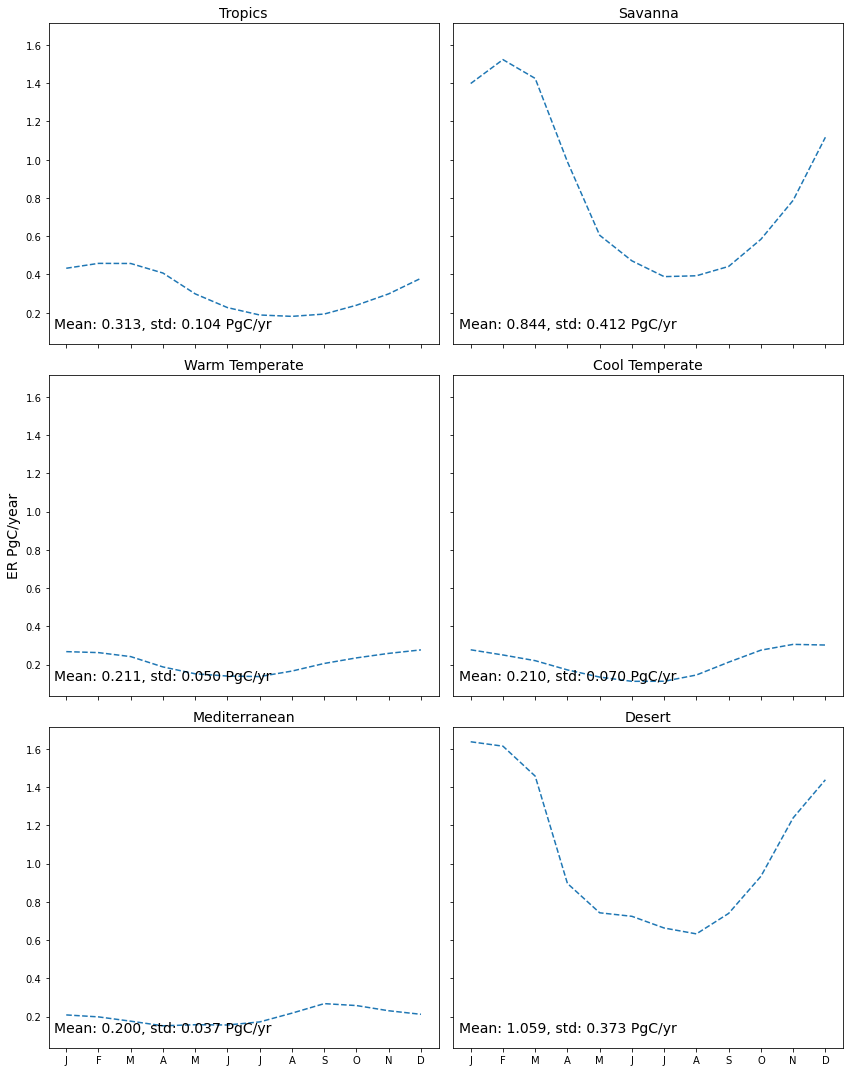

In [31]:
fig, axs = plt.subplots(3,2, figsize=(12,15), sharex=True, sharey=True)

for ax, k in zip(axs.ravel(), results.keys()):
    
    _1D = results[k].sum(['x','y'])
    
    _1D.plot(linestyle='--', ax=ax, label=var, )
    ax.text(.015, .05, f'Mean: {_1D.mean().values:.3f}, std: {_1D.std().values:.3f} PgC/yr',
        transform=ax.transAxes, fontdict={'fontsize': 14})
    if var=='NEE':
        ax.axhline(0, c='grey', linestyle='--')
    ax.set_title(k, fontdict={'fontsize': 14})
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xticks(range(1,13))
    ax.set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"]) 
fig.supylabel(var+' PgC/year', fontsize=14)
plt.tight_layout()
plt.savefig('/g/data/os22/chad_tmp/NEE_modelling/results/figs/'+var+'_bioregion_climatology.png')

## Interactive map

In [32]:
# import xarray as xr

In [33]:
# c4 = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/1km/LST_1km_monthly_2002_2021.nc').isel(time=1)

In [34]:
# c4.plot.imshow(size=15, robust = True)

In [35]:
# Create folium Map (ipyleaflet is also supported)
m = folium.Map()

# Plot each sample image with different colormap
# max_mean_month.plot.imshow(vmin=1, vmax=12, ax=ax[0], cmap='twilight', add_colorbar=False)
# np.absolute(scaled_variance).where(~mask).odc.add_to(m, opacity=1.0, cmap='magma', vmax=2)
max_mean_month.odc.add_to(m, opacity=1.0, cmap='twilight', vmin=1, vmax=12)


# Zoom map to Australia
m.fit_bounds(annual_mean.odc.map_bounds())

tile = folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = True,
        control = True
       ).add_to(m)

folium.LayerControl().add_to(m)
display(m)